## Цели практической работы

* Изучить и предобработать данные в задаче оттока.

* Научиться применять для решения задачи решающие деревья и оценивать результаты модели.

## Что входит в практическую работу

*  Загрузка и предобработка данных.
*  Применение и настройка линейных моделей.
*  Применение и настройка решающего дерева.
*  Сравнение моделей.
*  Оценка важности признаков.

## Что оценивается

Выполнены все задания ноутбука (заполнены пустые ячейки, даны ответы на вопросы).

In [46]:
import warnings
warnings.filterwarnings('ignore')

%pylab inline

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Что нужно сделать
Решите задачу классификации оттоковых клиентов телекома: для каждого клиента необходимо определить, перестанет он пользоваться услугами оператора в ближайшее время или нет.

In [2]:
df = pd.read_csv("data/telecom_churn.csv")
#df = pd.DataFrame(data)
print(df.shape)
df.head()

(3333, 20)


,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


Сделайте первичную обработку данных:

1. Выбросите колонку State.

2. Колонки International plan и Voice mail plan закодируйте следующим образом: Yes замените на 1, а No на 0.

3. Переведите целевую переменную (Churn) в числа: True в 1, а False в 0.

In [3]:
df.drop(['State'], axis=1, inplace=True)

# Замена 'Yes' на 1 и 'No' на 0
df['International plan'] = df['International plan'].map({'Yes': 1, 'No': 0})
df['Voice mail plan'] = df['Voice mail plan'].map({'Yes': 1, 'No': 0})

# Переводим переменную Churn в числа
df['Churn'] = df['Churn'].astype(int)

print(df.shape)
print(df.columns)
df.head()


(3333, 19)
Index(['Account length', 'Area code', 'International plan', 'Voice mail plan',
       'Number vmail messages', 'Total day minutes', 'Total day calls',
       'Total day charge', 'Total eve minutes', 'Total eve calls',
       'Total eve charge', 'Total night minutes', 'Total night calls',
       'Total night charge', 'Total intl minutes', 'Total intl calls',
       'Total intl charge', 'Customer service calls', 'Churn'],
      dtype='object')


,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


Выведите на экран первые строки изменённой таблицы, чтобы проверить, что все преобразования сработали.

In [4]:
df['Churn'].value_counts()

Churn
0    2850
1     483
Name: count, dtype: int64

Посмотрим и обработаем дубликаты и пропуски

учитывая дисбаланс удалим строки с пропусками где цель!=1

оставшиеся пропуски заполним медианой

In [5]:
# дубликаты
print(df.shape)
print('duplicated', sum(df.duplicated()), 'shape', df.shape)

# пропуски
missing_values = ((df.isna().sum() / len(df)) * 100).sort_values(ascending=False)
#print('missing', missing_values)

# создадим переменные содержащие пропуски
missing = missing_values[missing_values.values > 0].index.tolist()
print(missing)

# контролируем целевую переменную и удаляем......
print(df['Churn'].value_counts())
# Удаляем строки с отсутствующими значениями для заданных колонок, где 'Churn' == 0
df = df[~((df['Churn'] == 0) & (df[missing].isnull().any(axis=1)))]

# Заполним оставшиеся пропущенные значения модой
df.fillna(df.median().iloc[0], inplace=True)

print(df['Churn'].value_counts())
df.shape

(3333, 19)
duplicated 0 shape (3333, 19)
[]
Churn
0    2850
1     483
Name: count, dtype: int64
Churn
0    2850
1     483
Name: count, dtype: int64


(3333, 19)

Создайте матрицу объект-признак X и вектор с целевой переменной (Churn) y.

In [6]:
X = df.drop('Churn', axis=1)
y = df.Churn

Проверьте баланс классов. Является ли выборка сбалансированной?

In [7]:
y.value_counts()

Churn
0    2850
1     483
Name: count, dtype: int64

Разбейте данные на тренировочную и тестовую части, размер тестовой части — 30%.

In [8]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

Для линейных моделей очень важно масштабирование признаков. Поэтому отмасштабируйте признаки при помощи [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), обучив метод на тренировочных данных и применив его и к трейну, и к тесту.

In [9]:
X.dtypes

# Инициализация StandardScaler
scaler = StandardScaler()

# Обучение на тренировочных данных
x_train_scaled = scaler.fit_transform(x_train)

# Применение к тестовым данным
x_test_scaled = scaler.transform(x_test)

После масштабирования признаков X_train и X_test перестали быть объектами типа pd.DataFrame, это неудобно. Приведите их снова к pd.DataFrame.

In [10]:
X_train = pd.DataFrame(x_train_scaled, columns=x_train.columns)  # Восстанавливаем DataFrame с исходными колонками
X_test = pd.DataFrame(x_test_scaled, columns=x_test.columns)      # Восстанавливаем DataFrame с исходными колонками

X_train.head()

,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,-0.511937,1.740454,-0.324289,-0.612192,-0.585483,0.410716,0.873749,0.410877,1.167102,-1.646317,1.167733,-0.456961,0.615443,-0.458282,-0.373682,0.226639,-0.379643,1.073319
1,-0.939002,1.740454,-0.324289,-0.612192,-0.585483,-0.864713,1.074874,-0.865095,-2.639021,-1.895351,-2.637901,-0.790790,1.075039,-0.789925,-0.122835,-0.997316,-0.127479,1.073319
2,0.392435,1.740454,-0.324289,1.633475,0.289180,0.752053,0.370935,0.752000,-0.984185,0.893834,-0.983076,-0.425542,-1.018675,-0.423373,-0.445353,0.634624,-0.446002,0.323378
3,-0.738030,-0.515843,-0.324289,-0.612192,-0.585483,1.814605,0.471498,1.814230,-0.211928,-1.646317,-0.211288,1.070799,-0.814411,1.069020,0.522200,1.042609,0.522840,-1.176504
4,0.492921,1.740454,-0.324289,1.633475,2.548723,-0.038896,0.823467,-0.039276,-0.509404,-1.496896,-0.510269,-0.773117,0.870774,-0.772470,0.450529,-0.181346,0.456481,-0.426563


Обучите на тренировочных данных с параметрами по умолчанию:

1) логистическую регрессию;

2) метод опорных векторов (с kernel='linear').

In [11]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [12]:
svc = SVC(kernel='linear', probability=True)
svc.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

С помощью обученных моделей сделайте предсказание на тестовых данных. Вычислите значение метрики roc-auc на тесте. 

Не забудьте, что для корректного вычисления roc-auc необходимо предсказывать не сами классы, а их вероятности (чтобы SVC мог это сделать, при объявлении модели поставьте probability=True).

In [13]:
logreg_pred = logreg.predict_proba(X_test)[:,1].round(4)
res_logreg = roc_auc_score(y_test, logreg_pred)
print('logreg.roc_auc', res_logreg)

logreg.roc_auc 0.8282021362534782


In [14]:
svc_pred = svc.predict_proba(X_test)[:,1].round(4)
res_svc = roc_auc_score(y_test, svc_pred)
print('svc.roc_auc', res_svc)

svc.roc_auc 0.7401734787965827


Теперь обучите решающее дерево с параметрами по умолчанию на тренировочных данных, сделайте предсказание на тесте и вычислите на тесте roc-auc.

In [15]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
dtc_pred = dtc.predict_proba(X_test)[:,1].round(4)
res_dtc = roc_auc_score(y_test, dtc_pred)
print('dtc.roc_auc', res_dtc)

dtc.roc_auc 0.8391322796223614


Нужно ли масшабировать признаки для обучения решающего дерева? Проверьте это, заново разбив данные на тренировочную и тестовую части (назовите новые полученные объекты новыми названиями), и проведите обучение, предсказание и оценку метрики до масштабирования и после.

In [16]:
X = df.drop('Churn', axis=1)
y = df.Churn

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [17]:
# НЕ масштабированные данные для обучения

dtc_n = DecisionTreeClassifier()
dtc_n.fit(x_train, y_train)
dtc_n_pred = dtc_n.predict_proba(x_test)[:,1].round(4)
res_NOscaled_dtc = roc_auc_score(y_test, dtc_n_pred)
print('NOscaled_dtc.roc_auc', res_NOscaled_dtc)

NOscaled_dtc.roc_auc 0.8356276162577212


In [18]:
# Инициализация StandardScaler
scaler = StandardScaler()
# Обучение на тренировочных данных
x_train_scaled = scaler.fit_transform(x_train)
# Применение к тестовым данным
x_test_scaled = scaler.transform(x_test)

X_train = pd.DataFrame(x_train_scaled, columns=x_train.columns)  # Восстанавливаем DataFrame с исходными колонками
X_test = pd.DataFrame(x_test_scaled, columns=x_test.columns)      # Восстанавливаем DataFrame с исходными колонками

In [19]:
# МАСШТАБИРОВАННЫЕ данные для обучения

dtc_s = DecisionTreeClassifier()
dtc_s.fit(X_train, y_train)
dtc_s_pred = dtc_s.predict_proba(X_test)[:,1].round(4)
res_scaled_dtc = roc_auc_score(y_test, dtc_s_pred)
print('scaled_dtc.roc_auc', res_scaled_dtc)

scaled_dtc.roc_auc 0.8315558420575924


Какой вывод про масштабирование признаков для обучения дерева можно сделать?

При использовании решающих деревьев масштабирование признаков не является обязательным. Это связано с тем, что решающие деревья принимают решения, основываясь на пороговых значениях признаков, а не на расстояниях между ними.

Тем не менее, для более сложных моделей, которые могут включать в себя решающие деревья в качестве базовых моделей (например, в градиентном бустинге), масштабирование может иметь значение, особенно если используется функция потерь, чувствительная к масштабу значений.

Теперь ваша цель — максимально улучшить модели. Для этого:

1) у линейных моделей подберите гиперпараметр С (переберите 20 значений C в диапазоне от 0.1 до 10 с равным шагом);

2) у решающего дерева подберите max_depth (переберите глубину от 1 до 10 с шагом 1) и criterion — gini или entropy (см. [документацию](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)).

Для подбора параметров используйте [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) с пятью фолдами и метрикой roc-auc или обычные циклы.

Подбор параметров осуществляется только по тренировочным данным!

In [28]:
# Подбор параметров для LogisticRegression
param_grid_logreg = {'C': np.linspace(0.1, 10, 20)}
grid_logreg = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid_logreg, cv=5, scoring='roc_auc')
grid_logreg.fit(X_train, y_train)

print("Лучший гиперпараметр C для Logistic Regression:", grid_logreg.best_params_)
print("Лучший ROC AUC для Logistic Regression:", grid_logreg.best_score_)

Лучший гиперпараметр C для Logistic Regression: {'C': 0.6210526315789474}
Лучший ROC AUC для Logistic Regression: 0.8028520717993624


In [34]:
# Подбор параметров для SVC
param_grid_svc = {'C': np.linspace(0.1, 10, 20)}
grid_svc = GridSearchCV(SVC(probability=True, kernel='linear'), param_grid_svc, cv=5, scoring='roc_auc')
grid_svc.fit(X_train, y_train)

print("Лучший гиперпараметр C для SVC:", grid_svc.best_params_)
print("Лучший ROC AUC для SVC:", grid_svc.best_score_)

Лучший гиперпараметр C для SVC: {'C': 0.1}
Лучший ROC AUC для SVC: 0.7538706728393553


у решающего дерева подберите max_depth (переберите глубину от 1 до 10 с шагом 1) и criterion — gini и entropy, Для подбора параметров используйте GridSearchCV с пятью фолдами и метрикой roc-auc

In [30]:
# Определение параметров для подбора
param_grid = {
    'max_depth': np.arange(1, 11),  # Глубина от 1 до 10
    'criterion': ['gini', 'entropy']  # Критерии
}

# Создание модели
clf = DecisionTreeClassifier(random_state=42)

# Настройка GridSearchCV
grid_search = GridSearchCV(estimator=clf,
                           param_grid=param_grid,
                           scoring='roc_auc',  # Используем метрику roc-auc
                           cv=5,               # 5 фолов
                           n_jobs=-1)         # Используем все доступные ядра

# Подбор параметров
grid_search.fit(X_train, y_train)

# Получение результатов
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Лучшие параметры:", best_params)
print("Лучший roc-auc:", best_score)

Лучшие параметры: {'criterion': 'gini', 'max_depth': 5}
Лучший roc-auc: 0.8759538330010661


После подбора гиперпараметров обучите модели с найденными гиперпараметрами на тренировочных данных, сделайте предсказания на тесте и оцените их качество (roc_auc).

In [32]:
print("Лучший гиперпараметр C для Logistic Regression:", grid_logreg.best_params_)
print("Лучший гиперпараметр C для SVC:", grid_svc.best_params_)
print("Лучшие параметры DTC:", best_params)

Лучший гиперпараметр C для Logistic Regression: {'C': 0.6210526315789474}
Лучший гиперпараметр C для SVC: {'C': 2.7052631578947373}
Лучшие параметры DTC: {'criterion': 'gini', 'max_depth': 5}


In [35]:
logreg_c = LogisticRegression(C=0.6210526315789474)
logreg_c.fit(X_train, y_train)

logreg_c_pred = logreg_c.predict_proba(X_test)[:,1]
res_logreg_c = roc_auc_score(y_test, logreg_c_pred)
print('logreg_c.roc_auc', res_logreg_c)

logreg_c.roc_auc 0.8280062994182015


In [36]:
svc_c = SVC(C=2.7052631578947373, kernel='linear', probability=True)
svc_c.fit(X_train, y_train)

svc_c_pred = svc_c.predict_proba(X_test)[:,1]
res_svc_c = roc_auc_score(y_test, svc_c_pred)
print('svc_c.roc_auc', res_svc_c)

svc_c.roc_auc 0.7142006185180048


In [37]:
# НЕ масштабированные данные для обучения

dtc_d = DecisionTreeClassifier(criterion='gini', max_depth=5)
dtc_d.fit(x_train, y_train)
dtc_d_pred = dtc_d.predict_proba(x_test)[:,1]
res_dtc_d = roc_auc_score(y_test, dtc_d_pred)
print('NOscaled_dtc_d.roc_auc', res_dtc_d)

NOscaled_dtc_d.roc_auc 0.9075364542108999


Какая модель справилась с решением задачи лучше всего по метрике roc-auc?

Нарисуйте roc-кривую для наилучшей модели.

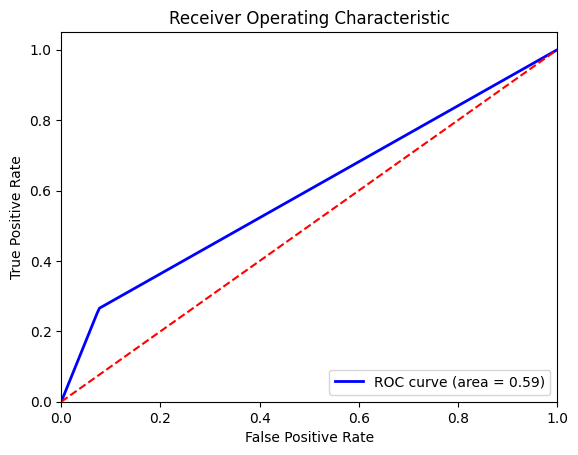

In [40]:
model = dtc_d
# Предсказания вероятностей
y_prob = model.predict_proba(X_test)[:, 1]

# Вычисление ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Построение ROC-кривой
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

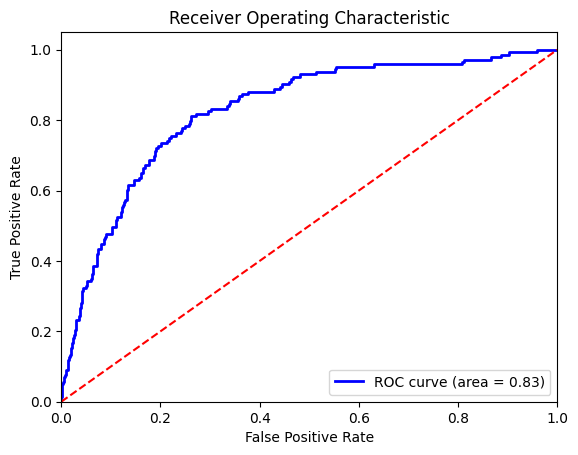

In [42]:
model = logreg_c
# Предсказания вероятностей
y_prob = model.predict_proba(X_test)[:, 1]

# Вычисление ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Построение ROC-кривой
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

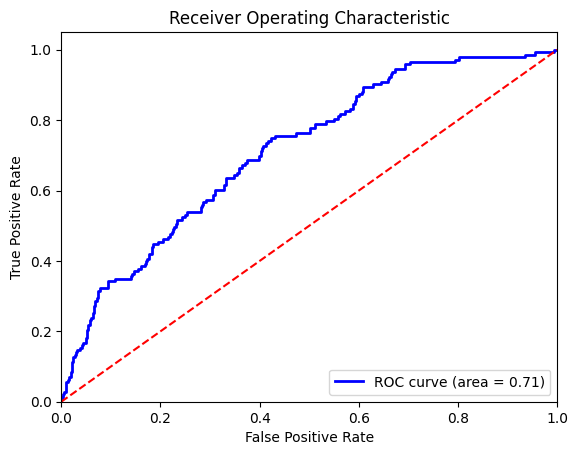

In [43]:
model = svc_c
# Предсказания вероятностей
y_prob = model.predict_proba(X_test)[:, 1]

# Вычисление ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Построение ROC-кривой
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Сравните между собой две лучшие модели:

1. Насколько сильно отличается качество предсказания на тестовых данных?
(Вычислите разность значений roc-auc.)

In [44]:
res_dtc_d - res_logreg_c

0.07953015479269843

2. Постройте гистограммы важности признаков (для линейных моделей берите модуль значений весов) для каждой из этих моделей. Сравните между собой списки из трёх самых важных признаков. Совпадают ли они?

Top 3 features for Logistic Regression:
    Feature  LogisticRegression       SVC  DecisionTree
17       17            0.661490  0.000081      0.165395
2         2            0.630246  0.000024      0.117369
3         3            0.599229  0.000233      0.060009

Top 3 features for SVC:
    Feature  LogisticRegression       SVC  DecisionTree
11       11            0.080135  0.044767      0.017957
13       13            0.076894  0.044674      0.000000
8         8            0.174183  0.020166      0.097853

Top 3 features for Decision Tree Classifier:
    Feature  LogisticRegression       SVC  DecisionTree
5         5            0.319829  0.009111      0.288163
17       17            0.661490  0.000081      0.165395
14       14            0.144254  0.007334      0.119492


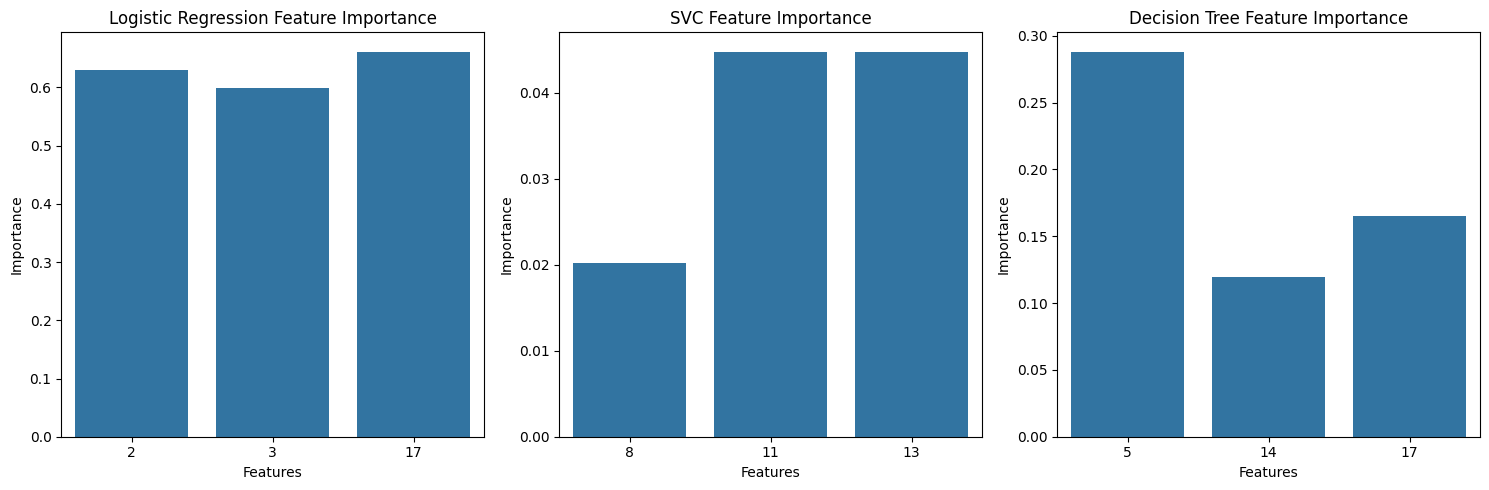

In [49]:
# Модель логистической регрессии
logreg_importance = np.abs(logreg_c.coef_[0])

# Модель поддержки векторных машин
svc_importance = np.abs(svc_c.coef_[0])

# Модель дерева решений
dtc_importance = dtc_d.feature_importances_

# Создание DataFrame для удобства работы
importance_df = pd.DataFrame({
    'Feature': range(X_test.shape[1]),  # замените на соответствующие названия признаков
    'LogisticRegression': logreg_importance,
    'SVC': svc_importance,
    'DecisionTree': dtc_importance
})

# Списки для трех самых важных признаков
top_logreg = importance_df.nlargest(3, 'LogisticRegression')
top_svc = importance_df.nlargest(3, 'SVC')
top_dtc = importance_df.nlargest(3, 'DecisionTree')

# Выводим три самых важных признака
print("Top 3 features for Logistic Regression:")
print(top_logreg)

print("\nTop 3 features for SVC:")
print(top_svc)

print("\nTop 3 features for Decision Tree Classifier:")
print(top_dtc)

# Построение гистограмм важности признаков
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.barplot(x=top_logreg['Feature'], y=top_logreg['LogisticRegression'])
plt.title('Logistic Regression Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')

plt.subplot(1, 3, 2)
sns.barplot(x=top_svc['Feature'], y=top_svc['SVC'])
plt.title('SVC Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')

plt.subplot(1, 3, 3)
sns.barplot(x=top_dtc['Feature'], y=top_dtc['DecisionTree'])
plt.title('Decision Tree Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')

plt.tight_layout()
plt.show()

Нет важность признаков для разных моделей не совпадает

Сделайте выводы:

1. Являются ли данные сбалансированными? Что это означает?

2. Какая модель после подбора гиперпараметров лучше всего решает задачу с точки зрения метрики roc-auc?

3. Одинаковые ли признаки важны для работы двух наилучших моделей? Почему?

1. в нашем конкретном случае данные являются несбалансированными, поскольку:

в целевой переменной имеется 2850 значений == 0

в то время как значений == 1 только 483

In [50]:
df['Churn'].value_counts()

Churn
0    2850
1     483
Name: count, dtype: int64

2. В данном случае наилучшей оказалась модель:

dtc_d = DecisionTreeClassifier(criterion='gini', max_depth=5)

с использованием немасштабированных данных

In [51]:
res_dtc_d

0.9075364542108999

3. Важность признаков для разных моделей не совпадает. 

Можно предполагать, что это связано с различнностью алгоритмов 
(математических формул) применяемых для обучения разных моделей.